# Глубокое обучение


## Тема 4. Авторегрессионные модели. Трансформеры. Модель GPT 🚀 

На прошлой паре мы строили генеративные модели для текстовых данных с помощью рекуррентных нейронных сетей (RNN), а именно, сети LSTM. Эта авторегрессионная модель обрабатывает последовательные данные по одному токену за раз, постоянно обновляя скрытый вектор, который фиксирует текущее скрытое представление входных данных. Сеть RNN может быть спроектирована так, чтобы предсказывать следующее слово в последовательности, применяя плотный слой и активацию `softmax` к скрытому вектору. Это считалось самым сложным способом генеративного моделирования текстовых данных до 2017 года, когда был предложен альтернативный подход.

#### Внимание (attention)

Статья сотрудников компании Google Brain, озаглавленная “Attention Is All You Need” («Внимание — это все, что вам нужно»), известна популяризацией концепции __внимания__ (attention) — механизма, который сейчас лежит в основе большинства современных моделей генерации текста.

В статье показано, как можно создавать мощные нейронные сети, называемые __трансформерами__ (Transformers), для последовательного моделирования, которые не требуют сложных рекуррентных или сверточных архитектур, а вместо этого полагаются только на механизмы внимания. Этот подход преодолевает ключевой недостаток подхода RNN, который заключается в том, что его сложно распараллелить, поскольку он должен обрабатывать последовательности по одному токену за раз. Трансформеры обладают высокой степенью распараллеливания, что позволяет обучать их на огромных наборах данных.

Разберемся, как современные модели генерации текста используют архитектуру __Transformer__ для достижения высочайшей производительности при решении задач генерации текста. В частности,  рассмотрим тип авторегрессионной модели, известный как генеративный предварительно обученный трансформер (generative pre-trained transformer или GPT), который лежит в основе модели GPT-4 компании OpenAI, которая считается современным уровнем генерации текста.

#### Модель GPT

Компания OpenAI представила модель GPT в июне 2018 года в статье “Improving Language Understanding by Generative Pre-Training” («Улучшение понимания языка посредством генеративного предварительного обучения») почти ровно через год после появления оригинальной статьи о Transformer.

В этой статье авторы показывают, как архитектуру Transformer можно обучить на огромном объеме текстовых данных, чтобы предсказывать следующее слово в последовательности, а затем затем точно настроить для конкретных последующих задач.

Процесс предварительного обучения модели GPT включает обучение модели на большом корпусе текста под названием BookCorpus (4,5 ГБ текста из 7000 неопубликованных книг разных жанров). Во время предварительного обучения модель обучается предсказывать следующее слово в последовательности с учетом предыдущих слов. Этот процесс известен как языковое моделирование и используется для обучения модели пониманию структуры и закономерностей естественного языка.

После предварительного обучения модель GPT можно точно настроить для конкретной задачи, предоставив ей меньший набор данных для конкретной задачи. Точная настройка включает в себя корректировку параметров модели для лучшего соответствия поставленной задаче. Например, модель можно точно настроить для таких задач, как классификация, оценка сходства или ответы на вопросы.

Архитектура GPT с тех пор была улучшена и расширена компанией OpenAI с выпуском последующих моделей, таких как GPT-2, GPT-3, GPT-3.5, GPT-4 и GPT-5. Эти модели обучаются на больших наборах данных и имеют большую емкость, поэтому могут генерировать более сложный и связный текст. Модели GPT получили широкое распространение среди исследователей и отраслевых практиков и способствовали значительному прогрессу в задачах обработки естественного языка.

Попробуем создать собственную версию исходной модели GPT, обученную на меньшем количестве данных, но по-прежнему использующую те же компоненты и основные принципы.

### Набор данных винных обзоров (Wine Reviews Dataset)

Мы будем использовать набор данных Wine Reviews, доступный через Kaggle (https://www.kaggle.com/datasets/zynicide/wine-reviews). Это набор из более чем 130 000 обзоров вин с сопутствующими метаданными, такими как описание и цена.

In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
tf.__version__

'2.18.0'

In [3]:
import json
import re
import string
from IPython.display import display, HTML

from tensorflow.keras import layers, models, losses, callbacks

## Параметры

In [4]:
VOCAB_SIZE = 10000
MAX_LEN = 80
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 2
FEED_FORWARD_DIM = 256
VALIDATION_SPLIT = 0.2
SEED = 42
LOAD_MODEL = False
BATCH_SIZE = 32
EPOCHS = 5

## Загрузка данных

Подготовка данных идентична подготовке данных для сети LSTM. Загружаем данные:

In [5]:
# Load the full dataset
with open("wine-reviews/winemag-data-130k-v2.json") as json_data:
    wine_data = json.load(json_data)

In [6]:
wine_data[10]

{'points': '87',
 'title': 'Kirkland Signature 2011 Mountain Cuvée Cabernet Sauvignon (Napa Valley)',
 'description': 'Soft, supple plum envelopes an oaky structure in this Cabernet, supported by 15% Merlot. Coffee and chocolate complete the picture, finishing strong at the end, resulting in a value-priced wine of attractive flavor and immediate accessibility.',
 'taster_name': 'Virginie Boone',
 'taster_twitter_handle': '@vboone',
 'price': 19,
 'designation': 'Mountain Cuvée',
 'variety': 'Cabernet Sauvignon',
 'region_1': 'Napa Valley',
 'region_2': 'Napa',
 'province': 'California',
 'country': 'US',
 'winery': 'Kirkland Signature'}

Создаем список текстовых описаний для каждого вина:

In [7]:
# Filter the dataset
filtered_data = [
    "wine review : "
    + x["country"]
    + " : "
    + x["province"]
    + " : "
    + x["variety"]
    + " : "
    + x["description"]
    for x in wine_data
    if x["country"] is not None
    and x["province"] is not None
    and x["variety"] is not None
    and x["description"] is not None
]

In [8]:
# Count the reviews
n_wines = len(filtered_data)
print(f"{n_wines} reviews loaded")

129907 reviews loaded


In [9]:
example = filtered_data[25]
print(example)

wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard-designated Pinot that hails from a high-elevation site. Small in production, it offers intense, full-bodied raspberry and blackberry steeped in smoky spice and smooth texture.


## Токенизируем данные

Дополним пунктуацию пробелами, чтобы каждый знак препинания воспринимался как отдельное слово.

In [10]:
# Pad the punctuation, to treat them as separate 'words'
def pad_punctuation(s):
    s = re.sub(f"([{string.punctuation}, '\n'])", r" \1 ", s)
    s = re.sub(" +", " ", s)
    return s


text_data = [pad_punctuation(x) for x in filtered_data]

In [11]:
# Display an example of a review
example_data = text_data[25]
example_data

'wine review : US : California : Pinot Noir : Oak and earth intermingle around robust aromas of wet forest floor in this vineyard - designated Pinot that hails from a high - elevation site . Small in production , it offers intense , full - bodied raspberry and blackberry steeped in smoky spice and smooth texture . '

Конвертируем список в датасет Tensorflow и пропустим текст через слой `TextVectorization`, который маркирует данные и дополняет/обрезает каждую строку до фиксированной длины.

In [12]:
# Convert to a Tensorflow Dataset
text_ds = (
    tf.data.Dataset.from_tensor_slices(text_data)
    .batch(BATCH_SIZE)
    .shuffle(1000)
)

I0000 00:00:1760468418.161992 15347940 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1760468418.162018 15347940 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
# Create a vectorisation layer
vectorize_layer = layers.TextVectorization(
    standardize="lower",
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_LEN + 1,
)

In [14]:
# Adapt the layer to the training set
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()

In [15]:
# Display some token:word mappings
for i, word in enumerate(vocab[:10]):
    print(f"{i}: {word}")

0: 
1: [UNK]
2: :
3: ,
4: .
5: and
6: the
7: wine
8: a
9: of


In [16]:
# Display the same example converted to ints
example_tokenised = vectorize_layer(example_data)
print(example_tokenised.numpy())

[   7   10    2   20    2   29    2   43   62    2   55    5  243 4145
  453  634   26    9  497  499  667   17   12  142   14 2214   43   25
 2484   32    8  223   14 2213  948    4  594   17  987    3   15   75
  237    3   64   14   82   97    5   74 2633   17  198   49    5  125
   77    4    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]


## Создание обучающего набора данных

Создадим обучающий набор данных, в котором входными данными являются векторы с токенами текста, а прогнозируемыми выходными данными являются те же векторы, смещенные на один токен влево и дополненные справа нулевым значением.

In [17]:
# Create the training set of recipes and the same text 
# shifted by one word
def prepare_inputs(text):
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


train_ds = text_ds.map(prepare_inputs)

In [18]:
example_input_output = train_ds.take(1).get_single_element()

In [19]:
# Example Input
example_input_output[0][0]

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([   7,   10,    2,  397,    2,  609,    2,  119,    2,  217,   14,
       2171,  782, 1455,   32,   12,   38,    3,   57,  227,   14,   58,
        119,   64,    9,   93,    3,  695,  224,   22,    5,   81,    4,
         15,   18,   21, 1654,    5, 2801, 2428,    3,  187, 1485,  408,
         11,    8,  396, 4171,    9,   95,   14,  149,   30,    4,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

In [20]:
# Example Output (shifted by one token)
example_input_output[1][0]

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([  10,    2,  397,    2,  609,    2,  119,    2,  217,   14, 2171,
        782, 1455,   32,   12,   38,    3,   57,  227,   14,   58,  119,
         64,    9,   93,    3,  695,  224,   22,    5,   81,    4,   15,
         18,   21, 1654,    5, 2801, 2428,    3,  187, 1485,  408,   11,
          8,  396, 4171,    9,   95,   14,  149,   30,    4,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

Схема создания обучающего набора данных показана ниже:

<!--img src="09_gpt_01.pdf" width=800-->

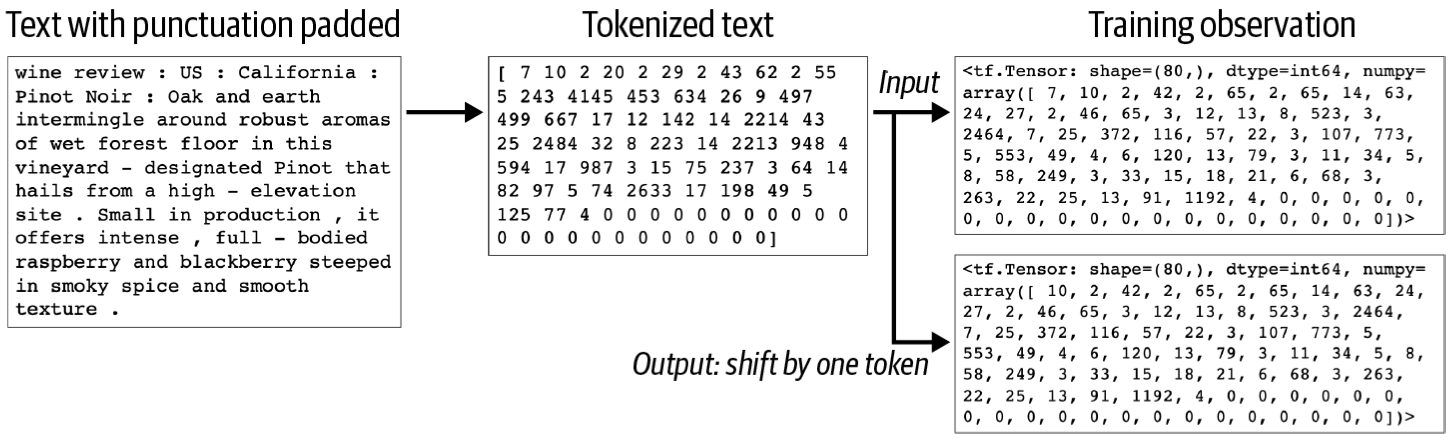

## Механизм внимания (attention)

Первый шаг к пониманию того, как работает модель GPT, — это понять, как работает механизм __внимания__. Именно этот механизм делает архитектуру трансформера уникальной и отличной от традиционных подходов к  моделированию текста. Когда мы разовьем четкое понимание внимания, мы увидим, как оно используется в архитектурах трансформера, таких как GPT.

Когда вы пишете фразу, на выбор следующего слова в предложении влияют другие слова, которые вы уже написали. Например, предположим, что вы начинаете предложение следующим образом:

>The pink elephant tried to get into the car but it was too 
(розовый слон пытался залезть в машину, но он был слишком)

Очевидно, что следующее слово должно быть каким-то синонимом слова «большой». Откуда нам это знать?

Некоторые другие слова в предложении важны для того, чтобы помочь нам принять решение. Например, тот факт, что это слон, а не ленивец, означает, что мы предпочитаем больших, а не медленных. Если бы это был бассейн, а не машина, мы могли бы выбрать страх как возможную альтернативу большому. Наконец, действие по посадке в машину подразумевает, что проблема заключается в размере: если бы слон вместо этого пытался раздавить машину, мы могли бы выбрать последнее слово «быстро», и теперь оно относится к машине.

Остальные слова в предложении совершенно не важны. Например, тот факт, что слон розовый, не влияет на наш выбор последнего слова. Равным образом второстепенные слова в предложении (the, But, It и т. д.) придают предложению грамматическую форму, но не важны для определения искомого прилагательного.
Другими словами, мы обращаем внимание на определенные слова в предложении и в значительной степени игнорируем другие. 
Механизм внимания в трансформере предназначен именно для этого. Он может решить, откуда из  входных данных он хочет получить информацию, чтобы эффективно извлекать полезную информацию, не запутываясь ненужными деталями. Это делает его легко адаптируемым к ряду обстоятельств, поскольку он может решать, где искать информацию во время генерации текста.

Напротив, рекуррентный слой пытается создать общее скрытое состояние, которое фиксирует общее представление входных данных на каждом временном шаге. Слабость этого подхода заключается в том, что многие слова, которые уже включены в скрытый вектор, не будут иметь прямого отношения к текущей задаче (например, предсказанию следующего слова), как мы только что видели. Механизм внимания не страдает от этой проблемы, поскольку он может выбирать, как комбинировать информацию из соседних слов, в зависимости от контекста.

### Запросы, ключи и значения

Каким образом __блок внимания__ (attention head) решает, где он хочет искать информацию? Давайте рассмотрим, как это работает на высоком уровне, на примере фразы про розового слона.

Представьте, что мы хотим предсказать, что следует за словом `too`. Чтобы помочь с этой задачей, другие предыдущие слова присоединяются к предсказанию со своими  мнениями, но их вклад взвешивается в зависимости от того, насколько они уверены в своей способности предсказывать слова, следующие за `too`. Например, слово `elephant` (слон) может с уверенностью утверждать, что это, скорее всего, слово, связанное с размером или громкостью, тогда как слово `was` (был) не может ничего предложить, чтобы сузить возможные слова.

Другими словами, мы можем думать о блоке внимания как о своего рода системе извлечения  информации, в которой запрос («Какое слово следует за `too`?») преобразуется в хранилище ключей/значений (другие слова в предложении), а результат представляет собой сумму значений, взвешенных по соответствию между запросом и каждым ключом.

Подробно рассмотрим этот процесс со ссылкой на фразу о розовом слоне.

<!--img src="09_gpt_02.pdf" width=600-->

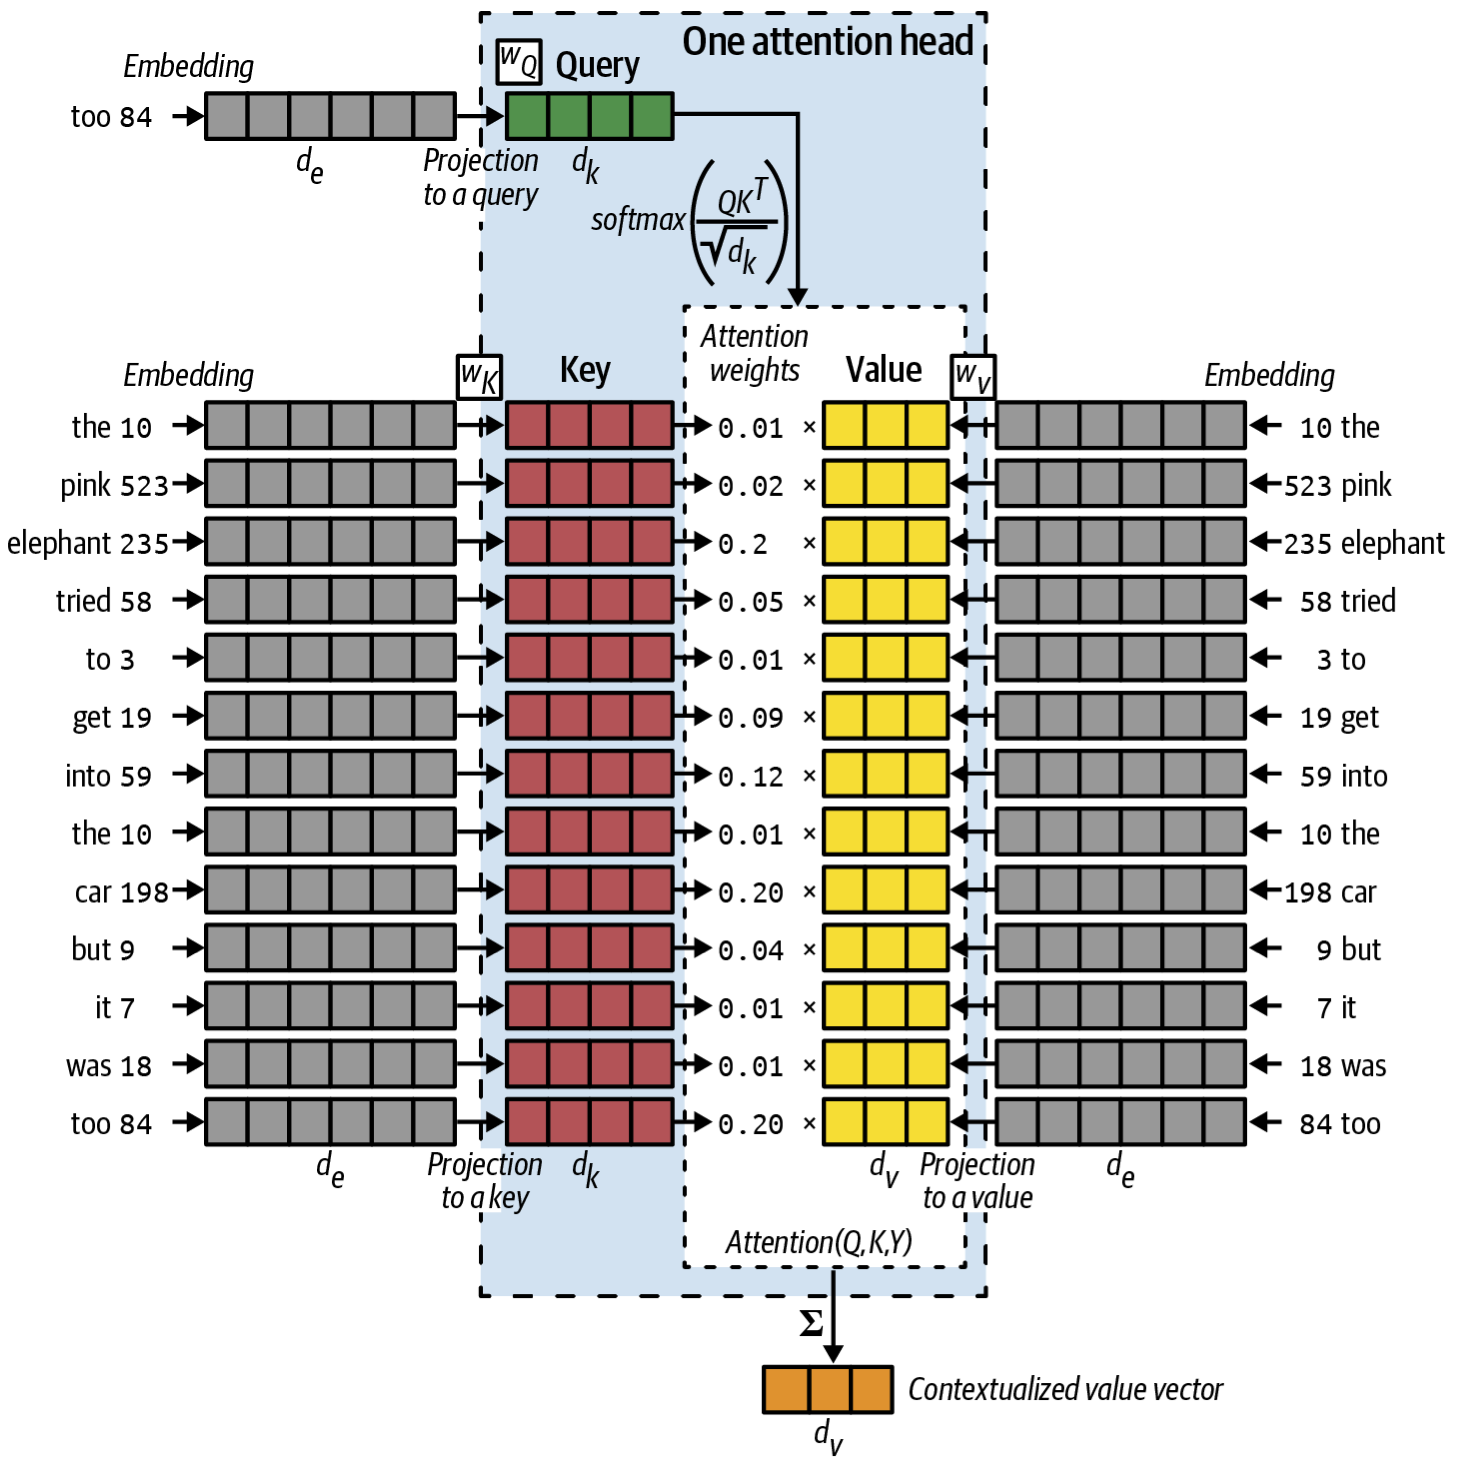

__Запрос__ (query) $Q$ можно рассматривать как представление текущей задачи (например, «Какое слово следует за `too`?»). Запрос получается из векторного представления (embedding) слова `too` путем его передачи через матрицу весов $W_Q$ для изменения размерности вектора с $d_e$ на $d_k$.

Векторы __ключей__ (key vectors) $K$ — это представления каждого слова в предложении. Их можно рассматривать как описания типов задач прогнозирования, с решением которых может помочь каждое слово. Они формируются аналогично запросу, путем передачи эмбединга каждого слова через матрицу весов $W_K$, изменяя размерность каждого вектора с $d_e$ на $d_k$. Ключи и запрос имеют одинаковую длину $d_k$.

Внутри __блока внимания__ (attention head) каждый ключ сравнивается с запросом с использованием скалярного (dot) произведения каждой пары векторов $Q K^T$. Именно поэтому ключи и запрос должны быть
одинаковой длины. Чем выше это значение для конкретной пары ключ/запрос, тем больше ключ соответствует запросу, поэтому ему разрешено вносить больший вклад в выходные данные блока внимания. Результирующий вектор масштабируется на величину $\sqrt{d_{k}}$, чтобы дисперсия суммы векторов оставалась стабильной (приблизительно равной 1), и далее применяется функция `softmax`, чтобы гарантировать, что сумма компонент равна 1. Так получается вектор __весов внимания__ (attention weights).

Векторы __значений__ (value vectors) $V$ также являются представлениями слов в предложении и могут быть интерпретированы как невзвешенный вклад каждого слова. Они получаются путем пропускания  вложения каждого слова через матрицу весов $W_V$ с изменением размерности каждого вектора с $d_e$ на $d_v$. Векторы значений не обязательно должны иметь ту же длину, что ключи и запрос (но для простоты часто так и бывает).

Векторы значений умножаются на веса внимания, чтобы получить значение внимания для заданных $Q$, $K$ и $V$, как показано в уравнении внимания

$$\mathrm{Attention}\left(Q,K,V\right)=\mathrm{softmax}\left(\frac{Q\,K^{T}}{\sqrt{d_{k}}}\right)\,V$$

Чтобы получить окончательный выходной вектор из блока внимания, внимание суммируется, чтобы получить вектор длины $d_v$. Этот вектор __контекста__ (context vector) отражает смешанное мнение слов в предложении о задаче предсказания, какое слово последует за слово `too`.

### Многомерное внимание

Нет причин останавливаться только на одном блоке внимания. В Keras можно создать слой `MultiHeadAttention`, который объединяет выходные данные нескольких блоков внимания, позволяя каждому из них изучить отдельный механизм внимания, чтобы слой в целом мог изучать более сложные отношения.

Объединенные выходные данные передаются через одну окончательную матрицу весов $W_O$ для проецирования вектора в желаемое выходное измерение, которое в нашем случае совпадает с входным измерением запроса $d_e$, так что слои можно укладывать последовательно поверх друг друга.

На рис. ниже показано, как формируются выходные данные слоя `MultiHeadAttention`. 

<!--img src="09_gpt_03.pdf" width=600-->

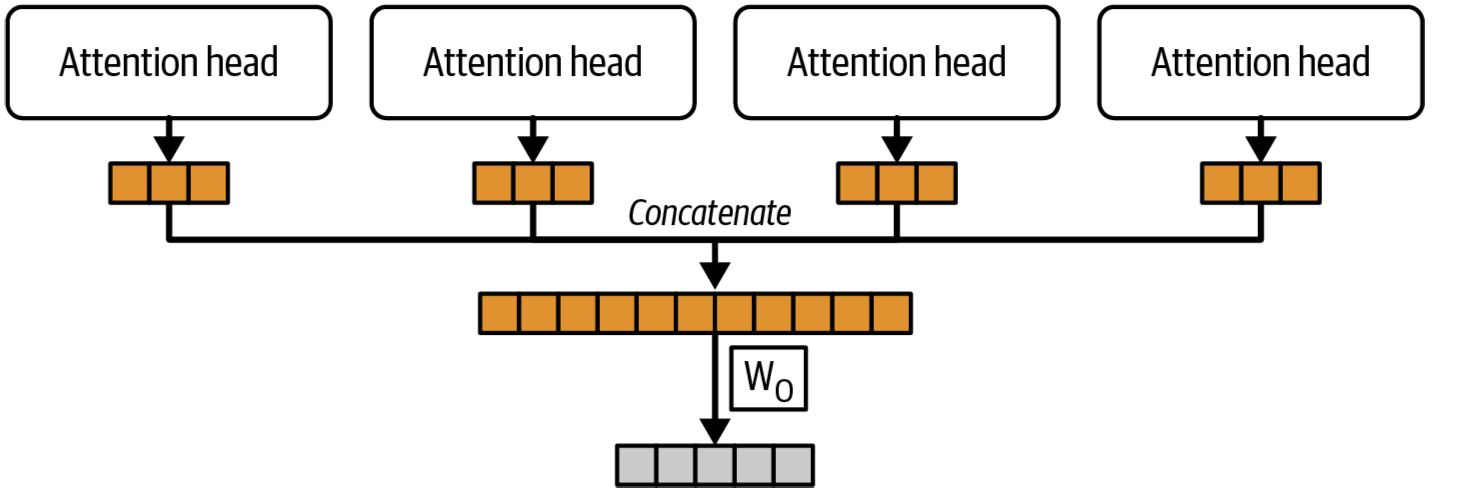

В Keras  для создания такого слоя можно написать следующий код:

```python
layers.MultiHeadAttention(
    num_heads = 4,
    key_dim = 128,
    value_dim = 64,
    output_shape = 256
    )
```

Этот слой многомерного внимания имеет четыре блока внимания. Ключи (и запрос) представляют собой векторы длиной 128. Значения (и, следовательно, также выходные данные каждого блока) представляют собой векторы длины 64. Выходной вектор имеет длину 256.

### Причинная маскировка (маскирование)

До сих пор предполагалось, что входные данные  запроса в блок внимания представляют собой один вектор. Однако для эффективности обучения в идеале хотелось бы, чтобы слой внимания мог работать с каждым словом во входных данных одновременно, предсказывая для каждого слова, каким будет последующее слово. Другими словами, мы хотим, чтобы наша модель GPT могла параллельно обрабатывать группу векторов запросов (т. е. матрицу).

Можно просто объединить векторы в матрицу, но нужен еще один шаг — нужно применить маску к скалярному произведению запроса/ключа, чтобы избежать утечки информации из будущих слов. Этот процесс известен как причинная маскировка (causal masking) и показано на рис. ниже.

<!--img src="09_gpt_04.pdf" width=600-->

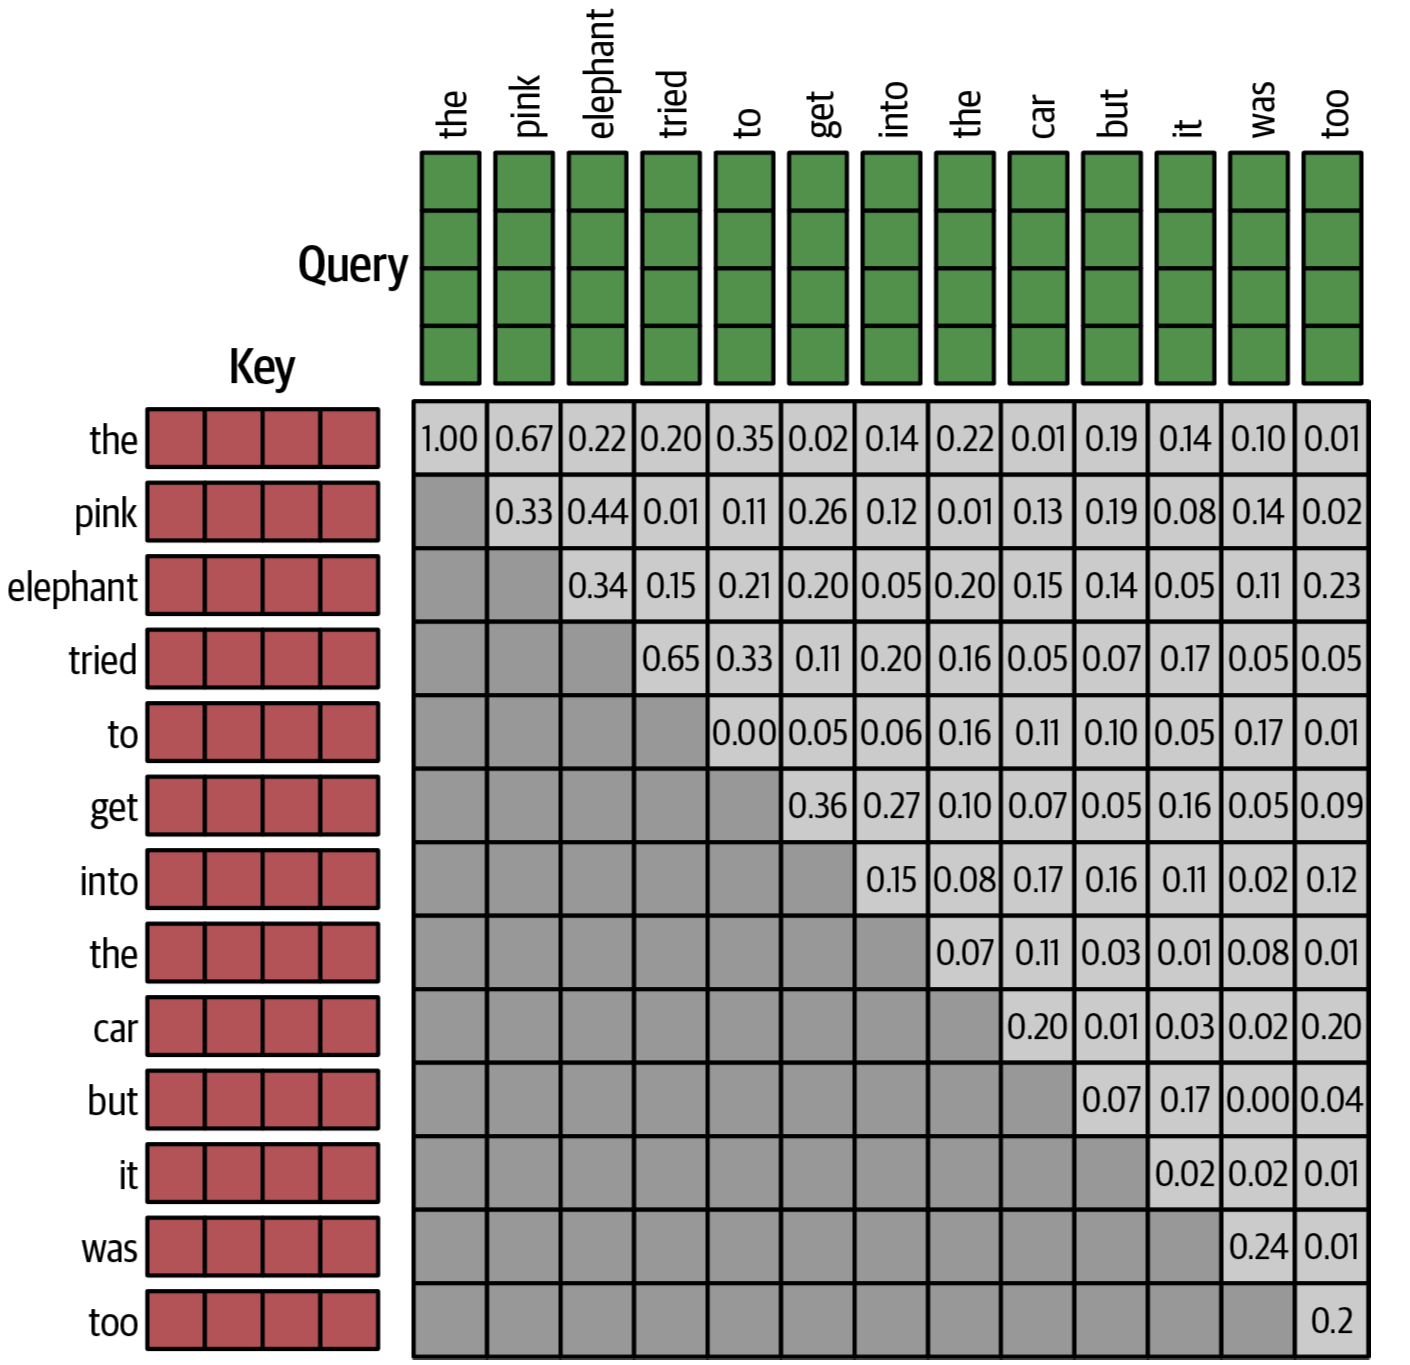

Цель причинной маскировки (использования маски причинного внимания) при матричном расчете оценок внимания для пакета входных запросов  – скрыть ключи, недоступные для запроса (поскольку они идут позже в предложении).

Без маскировки модель GPT смогла бы идеально угадать следующее слово в предложении, поскольку в качестве функции она использовала бы ключ самого слова. Код для создания причинной маски и полученный массив маски показаны ниже:

In [21]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), 
         tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

Причинное маскирование требуется только в трансформерах-декодерах, таких как GPT, где задача состоит в последовательной генерации токенов с учетом предыдущих токенов. Поэтому очень важно маскировать будущие токены во время обучения.
Другие разновидности трансформеров могут не нуждаться в причинной маскировке, поскольку они не обучены предсказывать следующий токен. 

Механизм многомерного внимания присутствует во всех трансформерах. Примечательно, что обучаемые параметры  слоя многомерного внимания состоят не более чем из трех  матриц весов для каждого блока внимания ($W_Q$, $W_K$, $W_V$) и еще одной матрицы весов для изменения выходной информации ($W_O$). В слое многомерного внимания нет сверток или повторяющихся (рекуррентных) частей.

Слой многомерного внимания образует лишь одну часть более крупного компонента, известного как блок трансформера.

## Блок трансформера

__Блок трансформера__ — это отдельный компонент внутри трансформера, который применяет некоторые сквозные связи  (skip connections), полносвязные (плотные) слои и нормализацию слоя многомерного внимания. Схема блока Трансформатора показана на рисунке ниже.

<!--img src="09_gpt_05.pdf" width=300-->

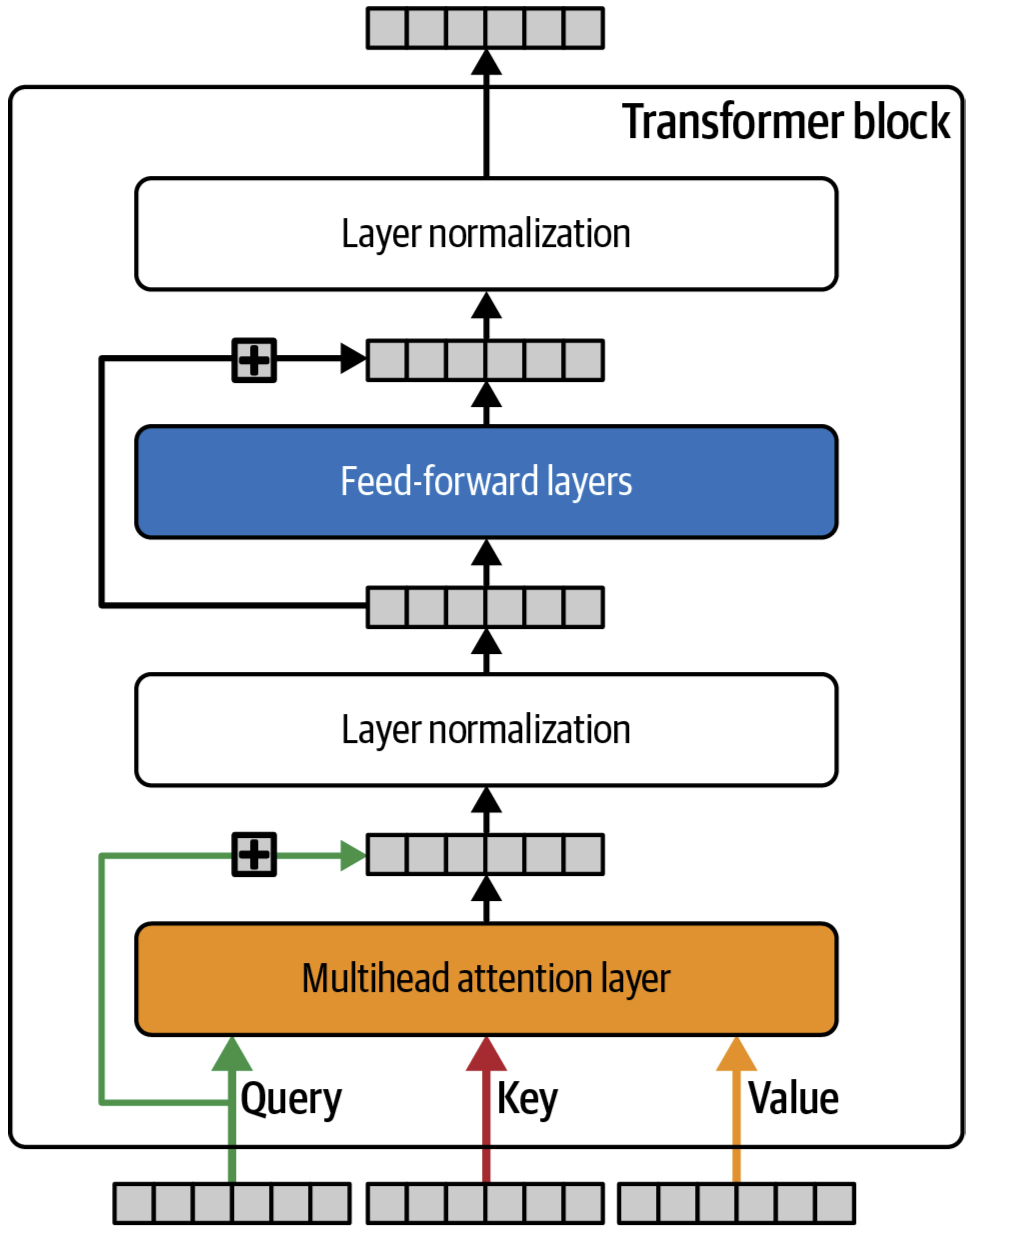

Запрос передается через  слой многомерного внимания и добавляется к выходным данным — это сквозные связи, часто встречающиеся в современных архитектурах глубокого обучения. Это означает, что можно построить очень глубокие нейронные сети, которые не так сильно страдают от проблемы исчезающего градиента, поскольку сквозные связи обеспечивают магистраль (highway) без градиента, что позволяет сети беспрепятственно передавать информацию вперед неискаженной.

В блоке трансформера используется нормализация слоев, чтобы обеспечить стабильность процесса обучения. В глубоком обучении применяются слои пакетной нормализации, где выходные данные каждого канала нормализуются так, чтобы среднее значение было равно 0, а стандартное отклонение равно 1. Статистика нормализации рассчитывается для пакетных и пространственных измерений.

Нормализация слоев в блоке Transformer нормализует каждую позицию каждой последовательности в пакете путем расчета статистики нормализации по каналам. Это полная противоположность пакетной нормализации с точки зрения расчета статистики нормализации. 

In [22]:
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, 
                 dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

### Позиционное кодирование

На уровне многомерного внимания нет ничего, что заботилось бы о порядке ключей. Скалярное произведение между каждым ключом и запросом вычисляется параллельно, а не последовательно, как в рекуррентной нейронной сети. Это сильная сторона (из-за повышения эффективности распараллеливания), но также и проблема, поскольку нам нужно, чтобы слой внимания имел возможность прогнозировать разные выходные данные для следующих двух предложений:
* The dog looked at the boy and ... (barked?)
* The boy looked at the dog and ... (smiled?)

Чтобы решить эту проблему, при создании входных данных для блока трансформера используется метод, называемый __позиционным кодированием__. Вместо того, чтобы кодировать каждый токен только с помощью эмбединга токена, мы также кодируем позицию токена, используя эмбединг позиции.

Эмбединг токена создается с использованием стандартного слоя эмбединга для преобразования каждого токена в вектор. Можно создать позиционный эмбединг таким же образом, используя стандартный слой эмбединга для преобразования каждой целочисленной позиции в вектор.


In [23]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = layers.Embedding(input_dim=max_len, 
                                        output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

## Построение модели трансформера

Чтобы собрать все в модель, нам нужно передать входной текст через слой эмбединга токена и позиции, а затем через блок трансформера. Конечным результатом работы сети является простой плотный слой с активацией `softmax` по количеству слов в словаре.

In [24]:
inputs = layers.Input(shape=(None,), dtype=tf.int32)
x = TokenAndPositionEmbedding(
    MAX_LEN, VOCAB_SIZE, EMBEDDING_DIM
)(inputs)
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM
)(x)
outputs = layers.Dense(VOCAB_SIZE, activation="softmax")(x)
gpt = models.Model(inputs=inputs, outputs=[outputs, attention_scores])
gpt.compile("adam", loss=[losses.SparseCategoricalCrossentropy(), None])

In [25]:
gpt.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, None, 256)      │     2,580,480 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ [(None, None, 256),    │       658,688 │
│ (TransformerBlock)              │ (None, 2, None, None)] │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, None, 10000)    │     2,570,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,809,168 (22.16 MB)

 Trainable params: 5,809,168 (22.16 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
if LOAD_MODEL:
    # model.load_weights('./models/model')
    gpt = models.load_model("./models/gpt", compile=True)

## Обучение трансформера

In [27]:
# Create a TextGenerator checkpoint
class TextGenerator(callbacks.Callback):
    def __init__(self, index_to_word, top_k=10):
        self.index_to_word = index_to_word
        self.word_to_index = {
            word: index for index, word in enumerate(index_to_word)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def generate(self, start_prompt, max_tokens, temperature):
        start_tokens = [
            self.word_to_index.get(x, 1) for x in start_prompt.split()
        ]
        sample_token = None
        info = []
        while len(start_tokens) < max_tokens and sample_token != 0:
            x = np.array([start_tokens])
            y, att = self.model.predict(x, verbose=0)
            sample_token, probs = self.sample_from(y[0][-1], 
                                                   temperature)
            info.append(
                {
                    "prompt": start_prompt,
                    "word_probs": probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_tokens.append(sample_token)
            start_prompt = start_prompt + " " + \
                           self.index_to_word[sample_token]
        print(f"\ngenerated text:\n{start_prompt}\n")
        return info

    def on_epoch_end(self, epoch, logs=None):
        self.generate("wine review", max_tokens=80, temperature=1.0)

In [28]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
text_generator = TextGenerator(vocab)

In [29]:
gpt.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, 
               tensorboard_callback, 
               text_generator],
)

Epoch 1/5
4059/4060 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.8224
generated text:
wine review : france : washington : mourvèdre : has aromas of mocha and prune with a rosé , one of this pleasing sparkler . it has smoothed it has a tart expression of zingy apple , the tart pear and pineapple . it has tang and appetizing texture with a immediately to nearly for its solidly between this wine in the mouthfeel with a bottle , rigid tannins . 

4060/4060 ━━━━━━━━━━━━━━━━━━━━ 143s 34ms/step - loss: 2.6813
Epoch 2/5
4059/4060 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.8368
generated text:
wine review : germany : mosel : riesling : the straightforward wine shows emerging structure , giving almost fruit and a rich and - berries counterparts to produce a few mildly based and single mountains of lodi . a deep structure ' s lingers in its a details of caramel and finish . it ' s old and a cocktail grape a decent quaffer dry . 

4060/4060 ━━━━━━━━━━━━━━━━━━━━ 129s 32ms/step - loss: 2.8746
Epoch 

In [30]:
# Save the final model
gpt.save("./models/gpt.keras")

# Генерация текста при помощи трансформера

Будем использовать тот же класс `TextGenerator`, который использовался для генерации текста сетью LSTM, включая параметр температуры, который определяет, насколько детерминированным должен быть процесс выборки.


In [31]:
def print_probs(info, vocab, top_k=5):
    for i in info:
        highlighted_text = []
        for word, att_score in zip(
            i["prompt"].split(), np.mean(i["atts"], axis=0)
        ):
            highlighted_text.append(
                '<span style="background-color:rgba(135,206,250,'
                + str(att_score / max(np.mean(i["atts"], axis=0)))
                + ');">'
                + word
                + "</span>"
            )
        highlighted_text = " ".join(highlighted_text)
        display(HTML(highlighted_text))

        word_probs = i["word_probs"]
        p_sorted = np.sort(word_probs)[::-1][:top_k]
        i_sorted = np.argsort(word_probs)[::-1][:top_k]
        for p, i in zip(p_sorted, i_sorted):
            print(f"{vocab[i]}:   \t{np.round(100*p,2)}%")
        print("--------\n")

In [32]:
info = text_generator.generate(
    "wine review : us", max_tokens=80, temperature=1.0
)


generated text:
wine review : us : california : meaty : cedary smelling . blossom and green floor and red aromas - s hard up nonvintage and minimal quality of 34 fruit and black style leads by rust and wine . southern . the palate ' s it wait time . but acidity makes it into potential of green aromas on the first several a joy between aromas transition . 



In [33]:
info = text_generator.generate(
    "wine review : italy", max_tokens=80, temperature=0.5
)


generated text:
wine review : italy : tuscany : red blend : this delivers a touch of a touch of ripe , with a touch of candied and chocolate . the [UNK] and pineapple flavors of its acidity , with a good , full of light , and raspberry , with the a bit of [UNK] , with aromas . 



#### Просмотр оценок внимания

Мы также можем попросить модель сообщить нам, сколько внимания уделяется каждому слову при выборе следующего слова в предложении. Блок трансформера выводит веса внимания для каждого блока внимания, которые представляют собой распределение `softmax` по предыдущим словам в предложении.

Чтобы продемонстрировать это, на рис. ниже показаны пять главных токенов с наибольшей вероятностью трех разных входных подсказок, а также среднее внимание обеих блоков внимания по отношению к каждому предыдущему слову. Предыдущие слова окрашены в соответствии с их показателем внимания, усредненным по двум блокам внимания. Более темный синий означает, что слову уделяется больше внимания.

In [34]:
info = text_generator.generate(
    "wine review : germany", max_tokens=80, temperature=0.5
)
print_probs(info, vocab)


generated text:
wine review : germany : mosel : riesling : a sweet and this is a a bit a rich and [UNK] and plum and tannic , with a bit of [UNK] , with a bit of - fruit , with a hint of black currant , with a bit of citrus and grilled fruit , with a touch of the the french oak and black fruits . 



::   	99.83999633789062%
zealand:   	0.15000000596046448%
grosso:   	0.0%
red:   	0.0%
blend:   	0.0%
--------



mosel:   	94.44000244140625%
rheingau:   	1.3700000047683716%
::   	0.8600000143051147%
rheinhessen:   	0.8299999833106995%
s:   	0.36000001430511475%
--------



::   	99.91999816894531%
zealand:   	0.07999999821186066%
veltliner:   	0.0%
grosso:   	0.0%
mosel:   	0.0%
--------



riesling:   	95.86000061035156%
grüner:   	2.319999933242798%
pinot:   	0.7699999809265137%
chardonnay:   	0.5099999904632568%
rosé:   	0.25%
--------



::   	99.97000122070312%
veltliner:   	0.009999999776482582%
-:   	0.0%
blanc:   	0.0%
red:   	0.0%
--------



this:   	70.58999633789062%
a:   	14.119999885559082%
the:   	10.869999885559082%
made:   	0.7599999904632568%
[UNK]:   	0.550000011920929%
--------



touch:   	19.93000030517578%
hint:   	14.8100004196167%
bit:   	14.569999694824219%
little:   	4.03000020980835%
whiff:   	2.940000057220459%
--------



,:   	30.610000610351562%
and:   	22.739999771118164%
of:   	20.079999923706055%
-:   	7.510000228881836%
in:   	4.710000038146973%
--------



a:   	46.43000030517578%
the:   	13.989999771118164%
ripe:   	2.8499999046325684%
[UNK]:   	2.5399999618530273%
this:   	2.509999990463257%
--------



is:   	33.93000030517578%
with:   	30.809999465942383%
wine:   	17.549999237060547%
aromas:   	7.389999866485596%
has:   	1.9600000381469727%
--------



a:   	69.27999877929688%
the:   	12.770000457763672%
this:   	5.130000114440918%
with:   	2.7799999713897705%
it:   	1.0700000524520874%
--------



bit:   	18.780000686645508%
touch:   	12.380000114440918%
little:   	5.610000133514404%
hint:   	5.349999904632568%
rich:   	4.650000095367432%
--------



bit:   	17.670000076293945%
touch:   	12.609999656677246%
hint:   	6.75%
little:   	5.349999904632568%
rich:   	4.320000171661377%
--------



of:   	36.43000030517578%
a:   	18.389999389648438%
the:   	15.5600004196167%
this:   	6.489999771118164%
with:   	3.559999942779541%
--------



touch:   	19.43000030517578%
bit:   	16.459999084472656%
hint:   	15.579999923706055%
little:   	3.690000057220459%
ripe:   	2.799999952316284%
--------



.:   	25.139999389648438%
and:   	21.059999465942383%
with:   	20.209999084472656%
,:   	15.979999542236328%
of:   	11.449999809265137%
--------



a:   	37.290000915527344%
the:   	17.440000534057617%
this:   	3.059999942779541%
[UNK]:   	3.059999942779541%
ripe:   	2.759999990463257%
--------



,:   	47.0099983215332%
and:   	26.229999542236328%
.:   	18.790000915527344%
in:   	2.680000066757202%
-:   	0.8999999761581421%
--------



a:   	36.58000183105469%
the:   	15.430000305175781%
ripe:   	2.990000009536743%
black:   	2.759999990463257%
sweet:   	2.490000009536743%
--------



.:   	38.91999816894531%
flavors:   	21.979999542236328%
and:   	10.84000015258789%
,:   	8.65999984741211%
with:   	5.670000076293945%
--------



a:   	26.190000534057617%
the:   	11.720000267028809%
cherry:   	5.980000019073486%
black:   	5.170000076293945%
flavors:   	2.5299999713897705%
--------



,:   	74.9800033569336%
and:   	18.239999771118164%
.:   	1.6100000143051147%
wine:   	1.2400000095367432%
tannins:   	0.6299999952316284%
--------



with:   	92.33000183105469%
while:   	2.700000047683716%
but:   	1.1200000047683716%
it:   	0.9700000286102295%
flavors:   	0.5199999809265137%
--------



a:   	85.0%
the:   	10.850000381469727%
this:   	0.7300000190734863%
an:   	0.7099999785423279%
aromas:   	0.6000000238418579%
--------



hint:   	23.59000015258789%
touch:   	22.280000686645508%
bit:   	10.329999923706055%
whiff:   	3.0%
ripe:   	2.440000057220459%
--------



of:   	99.98999786376953%
a:   	0.0%
the:   	0.0%
this:   	0.0%
red:   	0.0%
--------



a:   	17.329999923706055%
the:   	8.199999809265137%
black:   	7.119999885559082%
acidity:   	3.8499999046325684%
cherry:   	3.75%
--------



,:   	39.599998474121094%
.:   	27.920000076293945%
and:   	25.700000762939453%
in:   	2.2699999809265137%
on:   	0.800000011920929%
--------



with:   	80.41000366210938%
but:   	9.489999771118164%
while:   	2.740000009536743%
and:   	2.4700000286102295%
it:   	1.809999942779541%
--------



a:   	83.31999969482422%
the:   	13.920000076293945%
an:   	0.6399999856948853%
this:   	0.5099999904632568%
its:   	0.2199999988079071%
--------



touch:   	27.790000915527344%
hint:   	23.020000457763672%
bit:   	12.25%
little:   	2.4200000762939453%
dry:   	1.9700000286102295%
--------



of:   	99.98999786376953%
a:   	0.0%
the:   	0.0%
this:   	0.0%
red:   	0.0%
--------



a:   	17.43000030517578%
the:   	8.609999656677246%
black:   	7.420000076293945%
acidity:   	5.590000152587891%
cherry:   	3.859999895095825%
--------



fruit:   	28.15999984741211%
cherry:   	14.069999694824219%
skinned:   	8.40999984741211%
-:   	4.980000019073486%
driven:   	4.699999809265137%
--------



,:   	62.38999938964844%
and:   	29.40999984741211%
.:   	5.349999904632568%
of:   	0.8100000023841858%
in:   	0.4099999964237213%
--------



with:   	74.30999755859375%
but:   	11.020000457763672%
and:   	4.71999979019165%
while:   	3.069999933242798%
it:   	2.450000047683716%
--------



a:   	91.37999725341797%
the:   	6.369999885559082%
an:   	0.6299999952316284%
its:   	0.14000000059604645%
ripe:   	0.14000000059604645%
--------



touch:   	25.809999465942383%
hint:   	22.670000076293945%
bit:   	13.819999694824219%
dry:   	2.180000066757202%
little:   	2.130000114440918%
--------



of:   	99.66999816894531%
by:   	0.30000001192092896%
to:   	0.009999999776482582%
from:   	0.009999999776482582%
in:   	0.0%
--------



a:   	12.34000015258789%
black:   	9.729999542236328%
the:   	7.570000171661377%
acidity:   	5.130000114440918%
cherry:   	4.760000228881836%
--------



cherry:   	29.81999969482422%
-:   	23.06999969482422%
fruit:   	14.960000038146973%
fruits:   	9.350000381469727%
currant:   	4.71999979019165%
--------



,:   	65.16999816894531%
and:   	29.8799991607666%
.:   	3.130000114440918%
of:   	0.7799999713897705%
in:   	0.27000001072883606%
--------



with:   	46.40999984741211%
spice:   	5.179999828338623%
black:   	3.5899999141693115%
cherry:   	3.4100000858306885%
but:   	3.4000000953674316%
--------



a:   	71.69999694824219%
the:   	21.790000915527344%
aromas:   	0.8899999856948853%
black:   	0.5799999833106995%
an:   	0.5299999713897705%
--------



hint:   	27.540000915527344%
touch:   	26.899999618530273%
bit:   	13.600000381469727%
little:   	2.140000104904175%
long:   	2.0799999237060547%
--------



of:   	99.98999786376953%
a:   	0.009999999776482582%
the:   	0.0%
more:   	0.0%
.:   	0.0%
--------



a:   	21.229999542236328%
the:   	8.970000267028809%
acidity:   	8.15999984741211%
black:   	5.309999942779541%
fruit:   	4.179999828338623%
--------



and:   	62.4900016784668%
.:   	18.31999969482422%
,:   	14.869999885559082%
flavors:   	1.0199999809265137%
with:   	0.8700000047683716%
--------



a:   	27.540000915527344%
the:   	8.5%
black:   	8.069999694824219%
cherry:   	7.139999866485596%
acidity:   	2.240000009536743%
--------



meat:   	52.52000045776367%
herb:   	8.199999809265137%
cherry:   	6.71999979019165%
pepper:   	4.449999809265137%
plum:   	2.490000009536743%
--------



,:   	57.63999938964844%
and:   	25.139999389648438%
.:   	14.399999618530273%
the:   	0.6100000143051147%
of:   	0.41999998688697815%
--------



with:   	75.54000091552734%
but:   	6.260000228881836%
it:   	5.329999923706055%
while:   	3.2300000190734863%
and:   	2.799999952316284%
--------



a:   	91.95999908447266%
the:   	4.900000095367432%
an:   	0.8399999737739563%
some:   	0.20000000298023224%
ripe:   	0.17000000178813934%
--------



hint:   	34.91999816894531%
touch:   	26.43000030517578%
bit:   	10.449999809265137%
long:   	2.0399999618530273%
little:   	1.649999976158142%
--------



of:   	100.0%
.:   	0.0%
to:   	0.0%
on:   	0.0%
by:   	0.0%
--------



a:   	17.469999313354492%
the:   	9.039999961853027%
black:   	6.769999980926514%
acidity:   	6.480000019073486%
fruit:   	4.21999979019165%
--------



the:   	22.719999313354492%
this:   	11.649999618530273%
wood:   	6.050000190734863%
[UNK]:   	5.150000095367432%
a:   	3.809999942779541%
--------



the:   	21.780000686645508%
this:   	10.619999885559082%
[UNK]:   	6.170000076293945%
wood:   	5.809999942779541%
vintage:   	4.159999847412109%
--------



oak:   	53.9900016784668%
,:   	22.8799991607666%
and:   	9.300000190734863%
tannins:   	1.4700000286102295%
black:   	1.2799999713897705%
--------



,:   	50.72999954223633%
and:   	27.389999389648438%
.:   	20.940000534057617%
on:   	0.17000000178813934%
of:   	0.14000000059604645%
--------



a:   	22.059999465942383%
the:   	13.289999961853027%
black:   	8.5%
cherry:   	6.21999979019165%
vanilla:   	2.9700000286102295%
--------



-:   	24.3700008392334%
cherry:   	22.299999237060547%
fruit:   	16.790000915527344%
fruits:   	8.960000038146973%
pepper:   	4.349999904632568%
--------



.:   	71.16999816894531%
,:   	22.1200008392334%
and:   	5.710000038146973%
that:   	0.23000000417232513%
on:   	0.20999999344348907%
--------



:   	89.20999908447266%
drink:   	6.369999885559082%
it:   	2.4600000381469727%
the:   	1.8600000143051147%
this:   	0.029999999329447746%
--------



## Задание

Используя материалы занятий, выполните следующие работы:
* выберите какой-либо язык программирования (C, C++, Python, Java, Swift и т.п.)
* найдите в интернет и загрузите примеры программ на выбранном языке программирования для обучения модели
* создайте две нейронные сети архитектуры LSTM и трансформер, обучите нейронные сети на загруженных текстах программ и сгенерируйте при помощи обученных нейронных сетей программы на выбранном языке программирования 